### **STEP ONE** OF DATA PROCESSING PIPELINE

##### This script imports data in which a Reliable Component Analysis was performed. Visual Stimulus was dual frequency tagged: F1 = 3 Hz(6), F2 = 3.75 Hs (7.5) (inverting stim). Each participant completed 2 sessions. For each session, a F1 and F2 bandpass filter was performed. So 1 single participant has 4 data files. This is for a frequency-based analysis of the LTP paradigm


In [49]:
# load packages
import numpy as np 
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
from itertools import chain

### Set Dir Path(s): MainDir, SaveDataDir

In [263]:
# Main Directory of processed file from MatLab
#MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\RCA\\' # set dir - with USB Drive
MainDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\RCA\\' # set dir - on my computer
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Aviable Files to choose from: {len(d)}')
print(f'Files on hand: {d}')
##############################################
FileN_f1 = d[0] # choose one
FileN_f2  = d[1]                         
file_path1 = os.path.join(MainDir, FileN_f1) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

file_path2 = os.path.join(MainDir, FileN_f2) # join paths and prep 2 load
print('Current WD:',file_path2) # does path exist ... ?
print('Does File #2 Exist?',os.path.exists(file_path1)) # yes or no

Aviable Files to choose from: 2
Files on hand: ['OfficialF1_rcaResults_Sweep_contrast sweeps.mat', 'Official_F2_rcaResults_Sweep_contrast sweeps.mat']
Current WD: C:\plimon\LTP_analysis\RCA_F1\RCA\OfficialF1_rcaResults_Sweep_contrast sweeps.mat
Does File #1 Exist? True
Current WD: C:\plimon\LTP_analysis\RCA_F1\RCA\Official_F2_rcaResults_Sweep_contrast sweeps.mat
Does File #2 Exist? True


In [127]:
# Save Data Dir ...
#SaveDataDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AllSubjSweepRCA\\' # set dir where files (.pkl, .csv) will be saved
SaveDataDir = 'C:\\plimon\\LTP_analysis\\RCA_F1\\' # set dir where files (.pkl, .csv) will be saved
FileOutName = 'AllSessionDataCombin_allHarms' 
newPath = os.path.join(SaveDataDir, FileOutName)
if not os.path.exists(SaveDataDir):
    os.makedirs(SaveDataDir)
print(f'Path to save data:{SaveDataDir}')
######################################################
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl' 
#FileNToMatlab = f'{FileOutName}_{fdnt}.h5' 
#FileN = f'{FileOutName}_{fdnt}.csv' 
NewFileNPath = os.path.join(SaveDataDir,FileN)
print('Full New File Dir: ', NewFileNPath)

Path to save data:C:\plimon\LTP_analysis\RCA_F1\
Full New File Dir:  C:\plimon\LTP_analysis\RCA_F1\AllSessionDataCombin_allHarms_20240517_111021.pkl


In [260]:
df_f1 = scipy.io.loadmat(file_path1)
df_f2 = scipy.io.loadmat(file_path2)

#### Load F1 and F2 RCA Data

In [264]:
rca_f1 = df_f1['rcaResult']['projectedData'][0,0]
f1 = [rca_f1[x,0] for x in range(rca_f1.shape[0])]

In [265]:
rca_f2 = df_f2['rcaResult']['projectedData'][0,0]
f2 = [rca_f2[x,0] for x in range(rca_f2.shape[0])]

In [266]:
# load subject names ...
SubNames = df_f1['rcaResult'][0,0][5]
FileName = [x[0][3:] for subjlist in SubNames for x in subjlist[0][2][0]]
#FileName = np.sort(FileName)
print(f'Total Data Files: {len(FileName)}')

Total Data Files: 4


#### Make Subj Session Name Format Uniform and extract sub ID 

In [267]:
# set all file names to the same hyphen format
FileName = [FileName.replace('_','-') for FileName in FileName]
#print(len(FileName))
#### Set some params we'll need
[NumCols, NumComps, b] = np.shape(f1[0]) # 24 x 4 x n-Trials
NumFiles = int(len(FileName))

#print(NumCols,NumCmps, b) # new data dims 
# Find How Many Subject Names There are ...
string_ind = '-'
uniqueSubs = []
SessFileType = []
for n in range(NumFiles):
    x = FileName[n] # single file name string ie: 'nl-xxxx_attnX'
    if string_ind in x:
        y = x.split(string_ind)[0] # subj number
        #print(y)
        z = x.split(string_ind)[1] # session condition name 
        #print(z)
        # from each session name extract import info that will help us index and exclude later on ..
        uniqueSubs.append(y) # store all participant numbers (repeating - will be sorted later)
        SessFileType.append(z) # store the condtion label

In [268]:
print(uniqueSubs)
print(SessFileType)

['2738', '345202', '345215', '345216']
['attnR', 'attnR', 'attnR', 'attnR']


In [269]:
# given double sessions.., how many unique participants do we have?
TotalFiles = np.array(uniqueSubs)
[NumSubs, SessCounts] = np.unique(TotalFiles, return_counts = True) # returns unique subject and how many sessions they did (should be 2)
print(f'Total Participants: {len(NumSubs)}')
# [FileQuants, TotSess] = np.unique(SessCounts, return_counts = True) # returns counts of how many subs did 1 session and 2 sessions 
# print(f'{TotSess[1]} Participants completed the study')
# print(f'{TotSess[0]} Participants did not complete the study')

Total Participants: 4


In [137]:
TwoSess = SessCounts == 2 # index of who completed 2 sessions ..
GoodSubjs = NumSubs[TwoSess] # subs who completed 2 sessions 
SingleSessSubjs = NumSubs[~TwoSess] # subs who did not complete 2 sessions 
print(f'Subjects with 2 files: {len(GoodSubjs)}')
print(GoodSubjs)
print()
print(f'Single Subjs: {SingleSessSubjs}')

Subjects with 2 files: 0
[]

Single Subjs: ['2738' '345202' '345215' '345216']


#### Have to add this step because I ran someone for attnR **twice** ... yikes ...

In [138]:
# makes sure paticipants did complete attnL and attnR
FNameCrit = ['attnL', 'attnR'] # session names 
CleanSubjs = [] 

for i in range(len(GoodSubjs)):
    subj = GoodSubjs[i]
    f_list = [x for x in FileName if subj in x] # import all strongs were sub number is 
    list_check  = np.sort(f_list) # abc order strings -  attnL and THEN attnR
    counter = 0
    for n in range(len(FNameCrit)):
        if FNameCrit[n] in list_check[n]: # expt label should match file name in same position
            counter = counter + 1 # if so add 1 
            if (n == 1) and (counter == 2): # if both files strings are different, append
                CleanSubjs.append(GoodSubjs[i])
        else: # if not, add em to the singletons ... 
            print(f'{GoodSubjs[i]} did not match file name for {FNameCrit[n]}, moving subj to proper file ind array')
            str_nm = (np.array([GoodSubjs[i]], dtype=object))
            SingleSubs = np.concatenate((str_nm, SingleSessSubjs))

#### How many participants **actually** completed both sessions:

In [139]:
print(f'{len(CleanSubjs)} Participants Completed AttnL and AttnR')
print(f'{len(SingleSubs)} Participants did not complete both sessions')
print(CleanSubjs)

0 Participants Completed AttnL and AttnR
11 Participants did not complete both sessions
[]


#### Store Data Files as AttnL and AttnR in order

In [140]:
FNameCrit = ['attnL', 'attnR']
FilePos = np.zeros((len(CleanSubjs), 2))

for name in range(len(CleanSubjs)):
    yIn = CleanSubjs[name] # import single subject who completed 2 sessions 
    all_files_avil = [x for x in FileName if yIn in x] # list
    all_files_avil = np.sort(all_files_avil) # might not be necessary but jic ...
    pos = [loc for loc, file in enumerate(FileName) if file in all_files_avil] # index position of files if files match attnL and attnR
    FilePos[name,:] = pos
#print(FilePos)

In [141]:
print(FileName)

['2738-attnR-cnt-20240319-1329', '345202-attnR-c-20240319-1745', '345215-attnR-c-20240319-1632', '345216-attnR-c-20240321-1547']


In [259]:
x = np.array(f1[56])
xf = x[:,0,:] # [48 x 78] 1f1 2f1 4f1 6f1
c,r = np.shape(xf)
ci = int(c/2)
ri = int(r/2)
ComplexData = np.zeros((2,ci,r))

realData= xf[:ci,:]
phaseData = xf[ci:,:]

for i in range(2):
    if i == 0:
        ComplexData[i,:,:] = realData
    else:
        ComplexData[i,:,:] = phaseData

harmonicData = {}
HamronicIndicies = np.arange(0,ci,6) # index to get 
for j in range(4):
    s = HamronicIndicies[j]
    e = s+6
    harmonicData[j] = ComplexData[:,s:e,:] 

IndexError: list index out of range

In [255]:
hd = harmonicData[0] # 2 x 6 x numtrials

p1 = hd[:,:,:ri] # pre 
p2 = hd[:,:,ri:] # post 

px_set = [p1,p2]

cplxValsRec = np.zeros((2,2,6)) # pre/postx real/imaginary values x per contrast sweep incriment
crfValsRec = np.zeros((2,6))

for pp in range(2):
    dIn = px_set[pp] # import pre or post data
    for sweep in range(6): # import data for 1 contrast only 
        avgVal = dIn[:,sweep,:] # 2 x 39 vals
        av = np.nanmean(avgVal,axis = 1)
        crfValsRec[pp,sweep] = np.hypot(av[0],av[1])
    cplxValsRec[pp,:,sweep] = av

crf_diff = crfValsRec[1,:] - crfValsRec[0,:]

(2, 2, 6)
(2, 6)


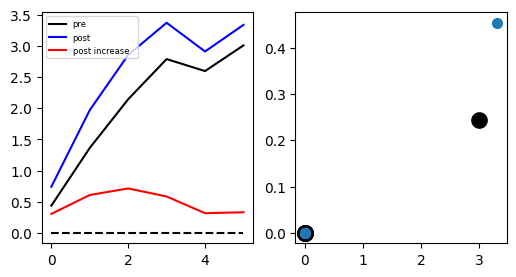

In [256]:
print(cplxValsRec.shape)
print(crfValsRec.shape)

fig,axs = plt.subplots(1,2,figsize =(6,3),sharey = False)
axs[0].plot(crfValsRec[0,:], label = 'pre', color = 'black')
axs[0].plot(crfValsRec[1,:], label = 'post', color = 'blue')
axs[0].plot(crf_diff, label = 'post increase  ', color = 'red')
axs[0].hlines(0, xmin = 0, xmax = 5, color = 'black', linestyles = 'dashed')
axs[0].legend(loc = 'upper left', fontsize = 6)


axs[1].scatter(cplxValsRec[0,0,:],cplxValsRec[0,1,:], label = 'pre complexs', linewidth  = 6, color = 'black')
axs[1].scatter(cplxValsRec[1,0,:],cplxValsRec[1,1,:], label = 'post complexs',linewidth  = 2 )

In [235]:
plt.hlines(linestyles)

NameError: name 'linestyles' is not defined

#### Create a big for loop to save all this data

In [ ]:
AttnL =  {'F1': [], 'F2': []} 
AttnR =  {'F1': [], 'F2': []} 
#AttnX =  {'F1': [], 'F2': []} 

# run a different file we imported (2 F1 and F2 filtered data) to save all in the same file
for iter in range(NumFiles):
    for ind in range(len(CleanSubjs)):
        attnL_FilePos = int(FilePos[ind,0])
        attnR_FilePos = int(FilePos[ind,1])
        if iter == 0:
            data = f1
            AttnL['F1'].append(data[attnL_FilePos])  # Append value to list in 'F1' key
            AttnR['F1'].append(data[attnR_FilePos])  # Append value to list in 'F1' key
        elif iter == 1:
            data = f2
            AttnL['F2'].append(data[attnL_FilePos])  # Append value to list in 'F2' key
            AttnR['F2'].append(data[attnR_FilePos])  # Append value to list in 'F2' key

### Now Saving Subjects data who only completed 1 session 

In [ ]:
SingleFiles_arr = []
for file in range(len(SingleSubs)):
    subIn = SingleSubs[file] # import one file at a time
    files_avil = [x for x in FileName if subIn in x]
    SingleFiles_arr.append(files_avil)

SinglefileNames = np.array(list(chain(*SingleFiles_arr))) #all single session names flattened
print(SinglefileNames)

In [ ]:
string_catch_L = 'attnL'
string_catch_R = 'attnR'
single_sess_ind = np.zeros(len(SinglefileNames)) # size of single sessions available
SingleSessSubName = [] # save subject name 
single_sess_pos = [] # find and store the data index 

for sInFName in range(len(SinglefileNames)):
    # determine whether its attnr or attnL
    fIn = SinglefileNames[sInFName]
    #find the postion of file in the data to organize later
    pos = [posi for posi, file in enumerate(FileName) if file in fIn]
    single_sess_pos.append(pos)

    x = fIn.split(string_ind)[1]
    y = fIn.split(string_ind)[0]
    SingleSessSubName.append(y)
    # make array to findex what files are attnL and attnR
    if string_catch_L in x:
        single_sess_ind[sInFName] = 1 # attnL ind == 1
    elif string_catch_R in x:
        single_sess_ind[sInFName] = 0 # attnL ind == 0

single_sess_pos = np.array(single_sess_pos)
# print(single_sess_pos)
# print(single_sess_ind)
# print(SingleSessSubName)

#### Index and save singles sessions as a seperate dict to export in pkl file

In [ ]:
single_sess_AttnL =  {'F1': [], 'F2': []} 
single_sess_AttnR =  {'F1': [], 'F2': []} 
l_subs = []
r_subs = []

for file_op in range(NumFiles):
    for oneSess in range(len(SinglefileNames)):
        sIn = SingleSessSubName[oneSess] # single sub names
        AttnXCond = single_sess_ind[oneSess] # condtion they did
        DataPos = single_sess_pos[oneSess] # position of data file is 
        DataPos = int(DataPos[0]) 

        if file_op == 0:
            dataIn = f1 # switch files 2 combine them
            if AttnXCond == 1:
                single_sess_AttnL['F1'].append(dataIn[DataPos]) # save data in this dict
                l_subs.append(sIn) # save subject name in this dict
            else:
                single_sess_AttnR['F1'].append(dataIn[DataPos])
                r_subs.append(sIn)

        elif file_op == 1:
            dataIn = f2 # switch files 2 combine them
            if AttnXCond == 1:
                single_sess_AttnL['F2'].append(dataIn[DataPos])
            else:
                single_sess_AttnR['F2'].append(dataIn[DataPos])


In [ ]:
SingleSessDataOut = {}

SingleSessDataOut[0] = single_sess_AttnL['F1']
SingleSessDataOut[1] = single_sess_AttnL['F2']
SingleSessDataOut[2] = single_sess_AttnR['F1']
SingleSessDataOut[3] = single_sess_AttnR['F2']

SingleSessDataOut['AttnLSubNames'] = np.array(l_subs)
SingleSessDataOut['AttnRSubNames'] = np.array(r_subs)
#SingleSessDataOut['DataNotes'] = ['keys: 0&1 attnL[f1/f2] and 2&3 attR[f1/f2], single session data']
print(SingleSessDataOut.keys())

In [ ]:
SessDataOut = {}

SessDataOut[0] = AttnL['F1']
SessDataOut[1] = AttnL['F2']
SessDataOut[2] = AttnR['F1']
SessDataOut[3] = AttnR['F2']

SessDataOut['FullSessSubjNames'] = CleanSubjs
SessDataOut['DataNotes'] = ['keys: 0&1 attnL[f1/f2] and 2&3 attR[f1/f2]']
print(SessDataOut.keys())

#### Save Data into .pkl file

In [ ]:
dataOut = {}

dataOut[0] = SessDataOut
dataOut[1] = SingleSessDataOut

In [ ]:
saveFile = 'y'

if saveFile == 'y':
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(dataOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    print('Sorted Data Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')